In [1]:
import pandas as pd

covid_data=pd.read_csv('data/covid_data.csv', sep=',')
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

covid_data['date'] = pd.to_datetime(covid_data['date'])

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

display(vaccinations_data)


country       date  total_vaccinations  people_vaccinated  \
0      Afghanistan 2021-02-22                 0.0                0.0   
1      Afghanistan 2021-02-23                 NaN                NaN   
2      Afghanistan 2021-02-24                 NaN                NaN   
3      Afghanistan 2021-02-25                 NaN                NaN   
4      Afghanistan 2021-02-26                 NaN                NaN   
...            ...        ...                 ...                ...   
42790     Zimbabwe 2021-09-01           4270430.0          2615233.0   
42791     Zimbabwe 2021-09-02           4323735.0          2649505.0   
42792     Zimbabwe 2021-09-03           4372216.0          2681657.0   
42793     Zimbabwe 2021-09-04           4400246.0          2698332.0   
42794     Zimbabwe 2021-09-05           4431599.0          2713248.0   

       people_vaccinated_per_hundred  people_fully_vaccinated  \
0                               0.00                      NaN   
1                                NaN                      NaN   
2                                NaN                      NaN   
3                                NaN                      NaN   
4                                NaN                      NaN   
...                              ...                      ...   
42790                          17.33                1655197.0   
42791                          17.56                1674230.0   
42792                          17.77                1690559.0   
42793                          17.88                1701914.0   
42794                          17.98                1718351.0   

       people_fully_vaccinated_per_hundred  daily_vaccinations  \
0                                      NaN                 NaN   
1                                      NaN              1367.0   
2                                      NaN              1367.0   
3                                      NaN              1367.0   
4                                      NaN              1367.0   
...                                    ...                 ...   
42790                                10.97             36416.0   
42791                                11.09             39711.0   
42792                                11.20             42317.0   
42793                                11.28             41413.0   
42794                                11.39             41964.0   

                                                vaccines  
0      Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...  
1      Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...  
2      Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...  
3      Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...  
4      Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...  
...                                                  ...  
42790  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  
42791  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  
42792  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  
42793  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  
42794  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  

[42795 rows x 9 columns]

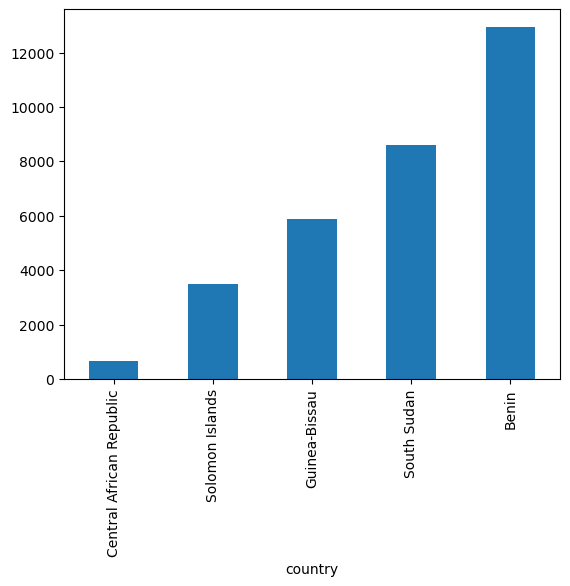

In [2]:
vaccinations_data['date'].agg(['max','min'])

covid_df=covid_data.merge(vaccinations_data, how='left')
covid_df['death_rate']=(covid_df['deaths']/covid_df['confirmed'])*100
covid_df['recovery_rate']=(covid_df['recovered']/covid_df['confirmed'])*100

covid_df[covid_df['country']=='Russia']['recovery_rate'].mean()

grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
""""grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость во времени',
    grid = True,
    lw=3
);"""

"""grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=30
);

grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
);

grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot(     kind='bar',     grid=True,     figsize=(12, 4), );"""

covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');

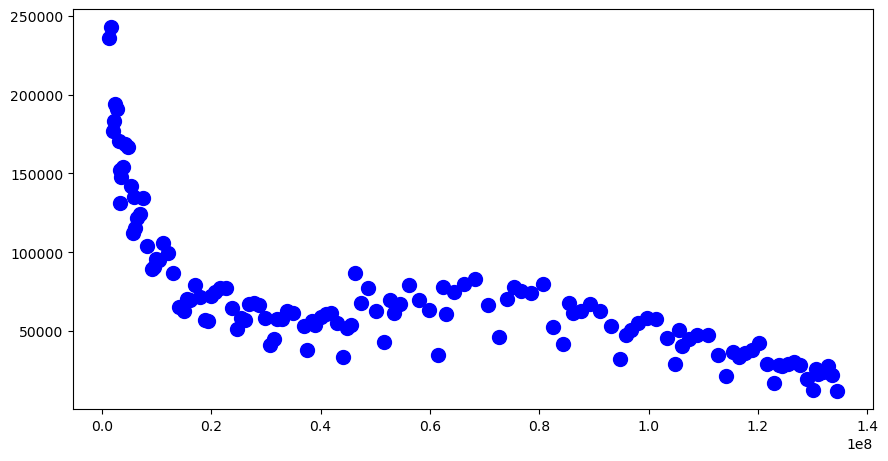

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')

us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(
    x=us_data['people_fully_vaccinated'], 
    y=us_data['daily_confirmed'], 
    s=100,
    marker='o',
    c = 'blue'
);

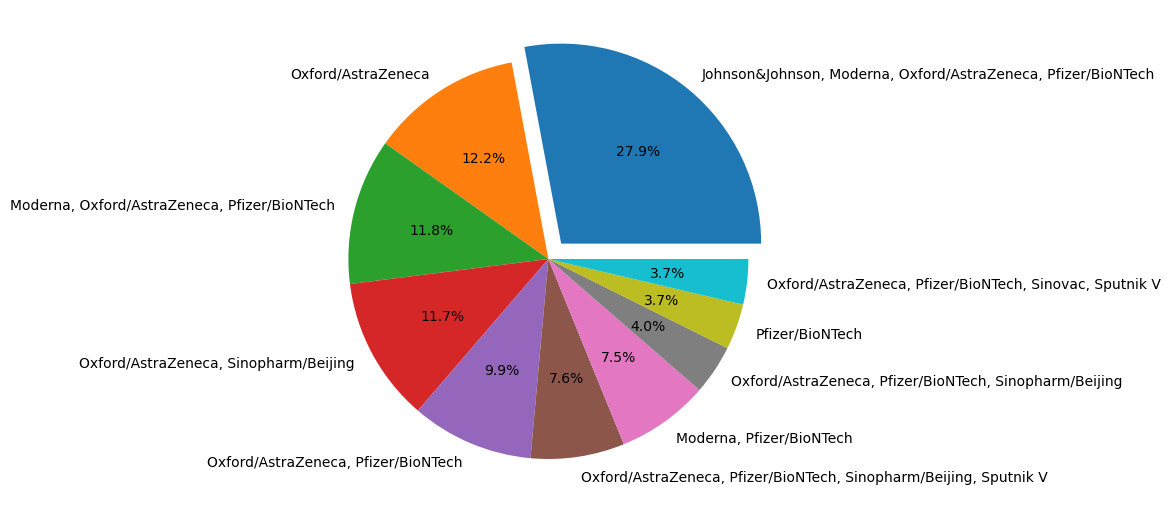

In [4]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccine_combinations,
    labels=vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

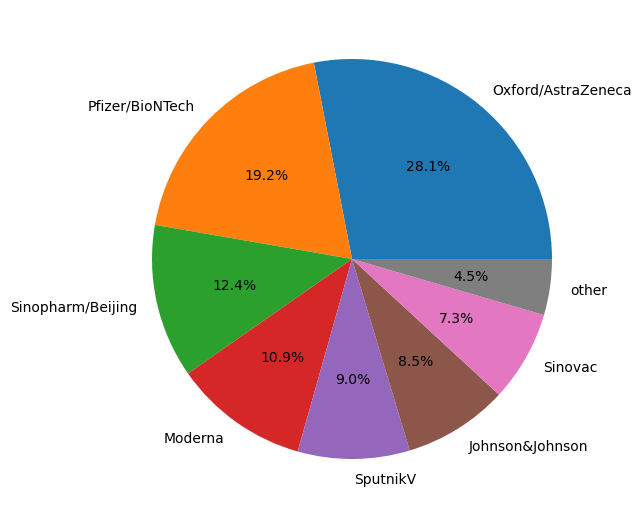

In [5]:
#избавляемся от пропусков в столбце с вакцинами
combination_not_nan = covid_df.dropna(subset=['vaccines'])
#группируем по странам и выбираем последнюю комбинацию вакцин в стране
combination_last = combination_not_nan.groupby(['country'])['vaccines'].last() 
#заменяем пробелы в строках и делим комбинации на отдельные вакцины по запятой
combination_last = combination_last.apply(lambda x: x.replace(' ', '').split(',')) 
#создаём пустой словарь, ключами которого будут вакцины, а значениями — количество стран
vaccines_dict = {} 
#создаём цикл по элементам Series combination_last
for vaccines_list in combination_last:
    #создаём цикл по элементам списка с вакцинами
    for vaccine in vaccines_list:
        #проверяем условие, что текущей вакцины ещё нет среди ключей словаря
        if vaccine not in vaccines_dict:#если условие выполняется
            vaccines_dict[vaccine] = 1 #заносим вакцину в словарь со значением 1
        else: #в противном случае
            vaccines_dict[vaccine] += 1 #увеличивает количество
#преобразуем словарь в Series
vaccines = pd.Series(vaccines_dict).sort_values(ascending=False)
#выделяем ТОП-7 вакцин и добавляем категорию 'other'
vaccines['other'] = vaccines[7:].sum()
vaccines = vaccines.sort_values(ascending=False)[:8]
#строим круговую диаграмму
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    vaccines,
    labels=vaccines.index,
    autopct='%.1f%%',
);

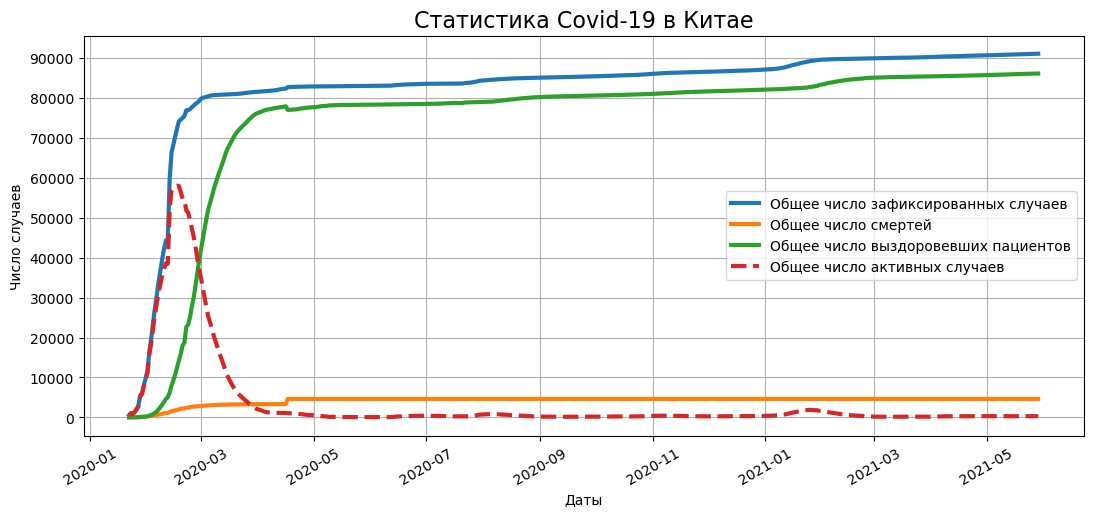

In [6]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

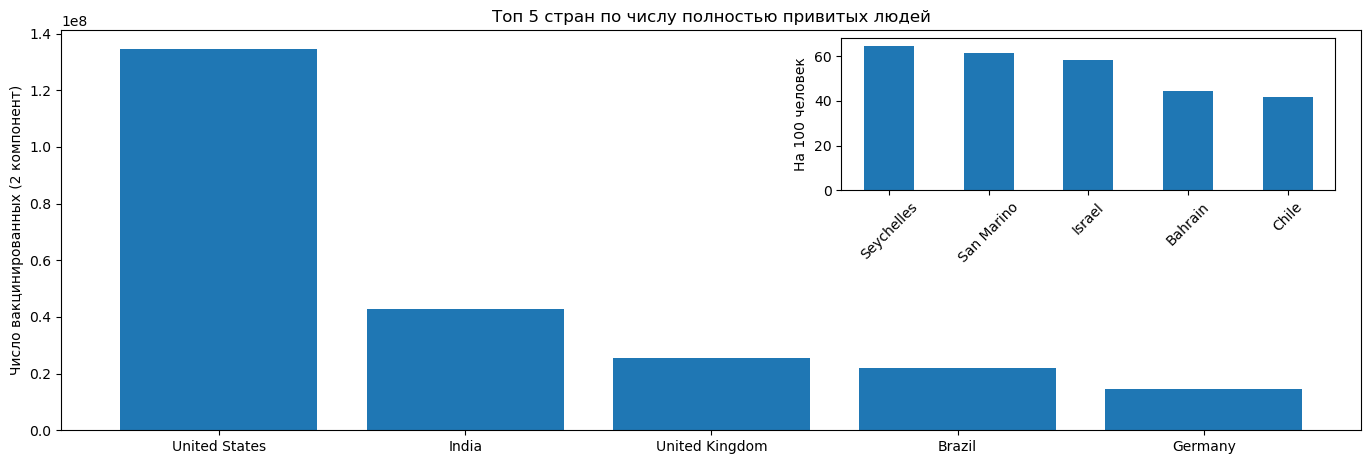

In [7]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

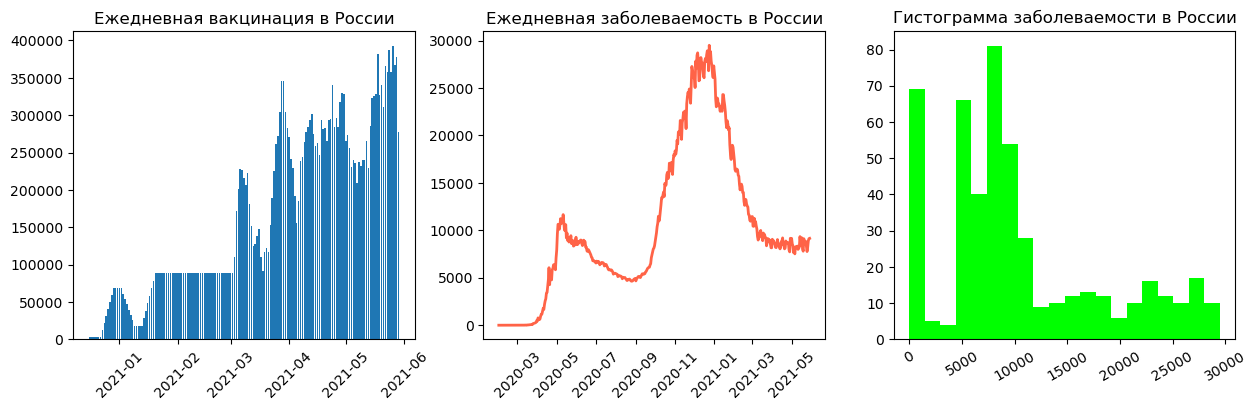

In [8]:
russia_data = covid_df[covid_df["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)



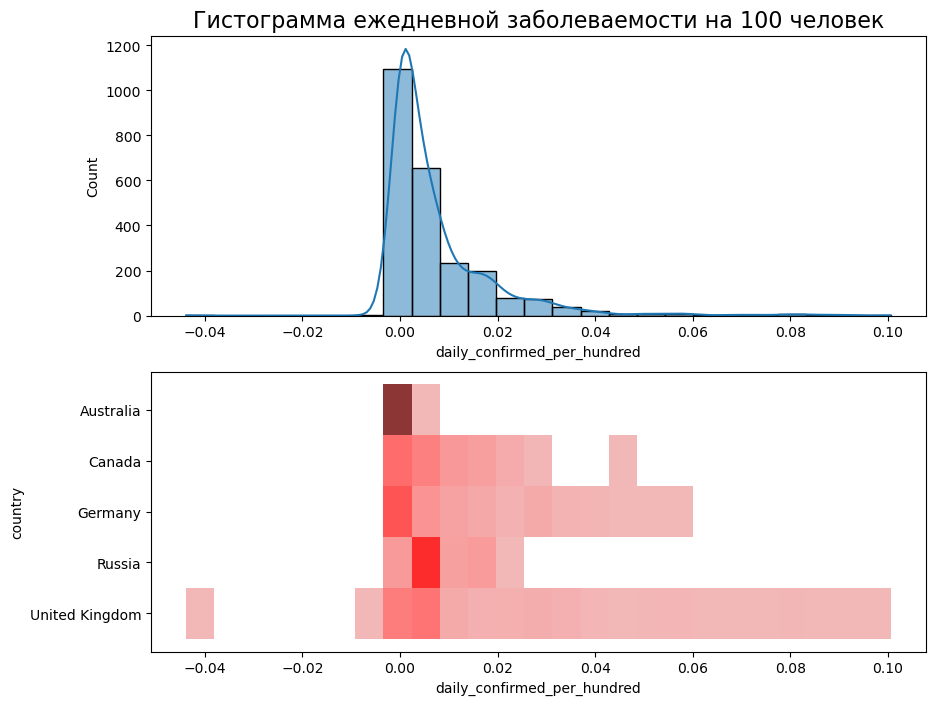

In [9]:
import seaborn as sns

countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);


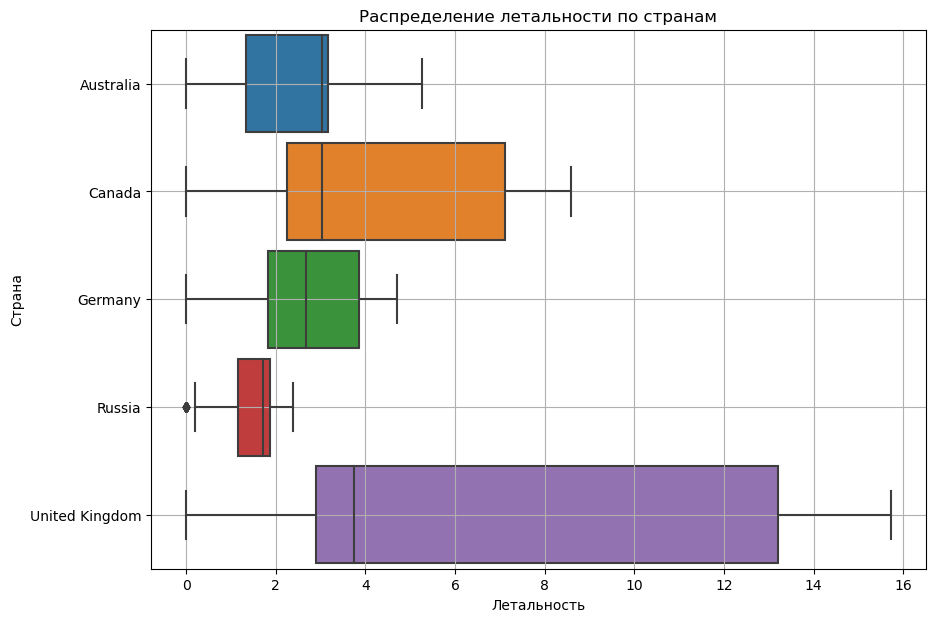

In [10]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

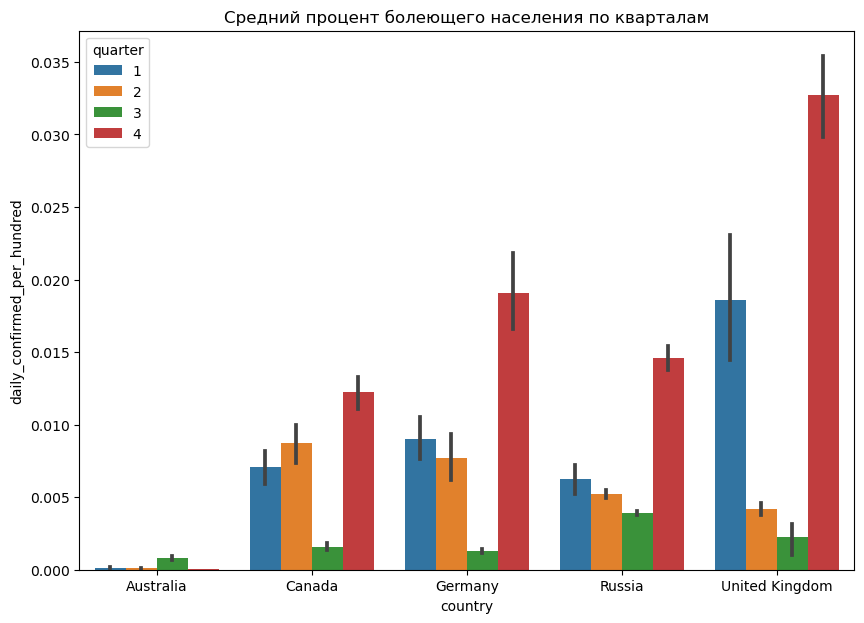

In [11]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');

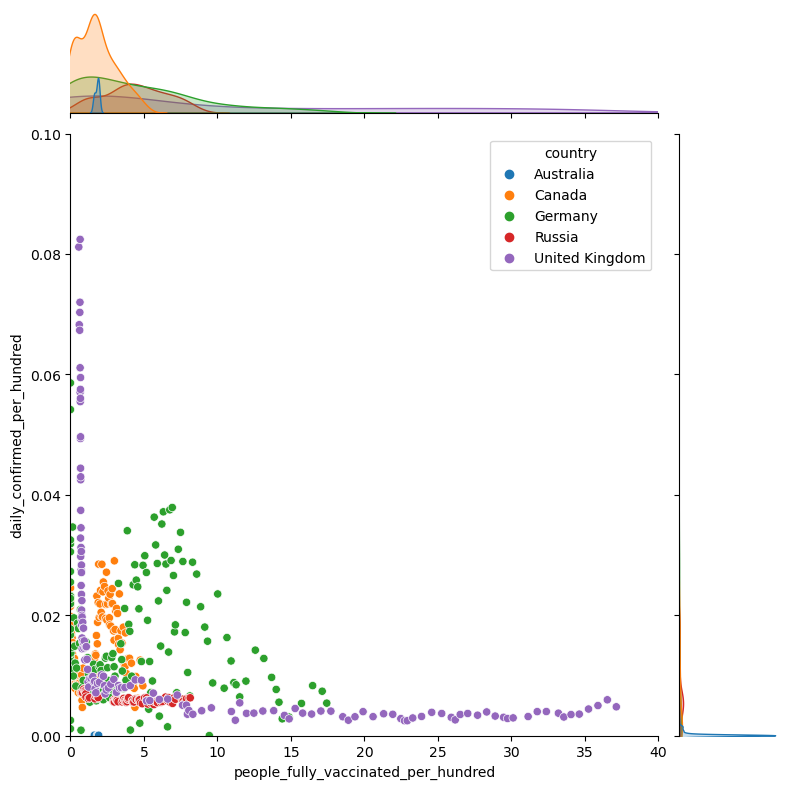

In [12]:
jointplot = sns.jointplot(
    data=croped_covid_df, 
    x='people_fully_vaccinated_per_hundred', 
    y='daily_confirmed_per_hundred',
    hue='country',
    xlim = (0, 40),
    ylim = (0, 0.1),
    height=8,
)

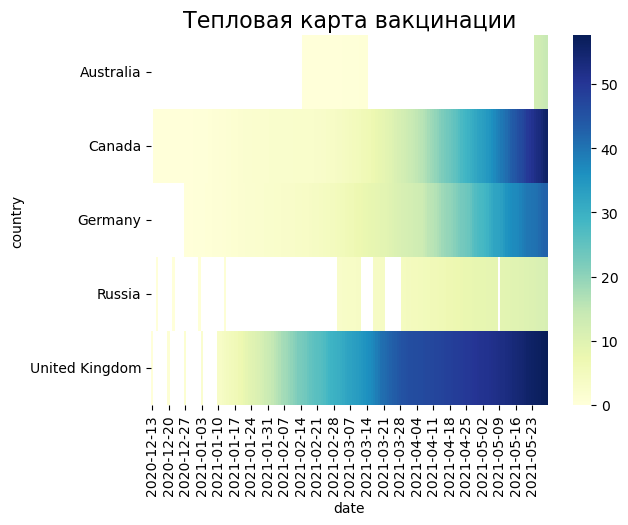

In [13]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

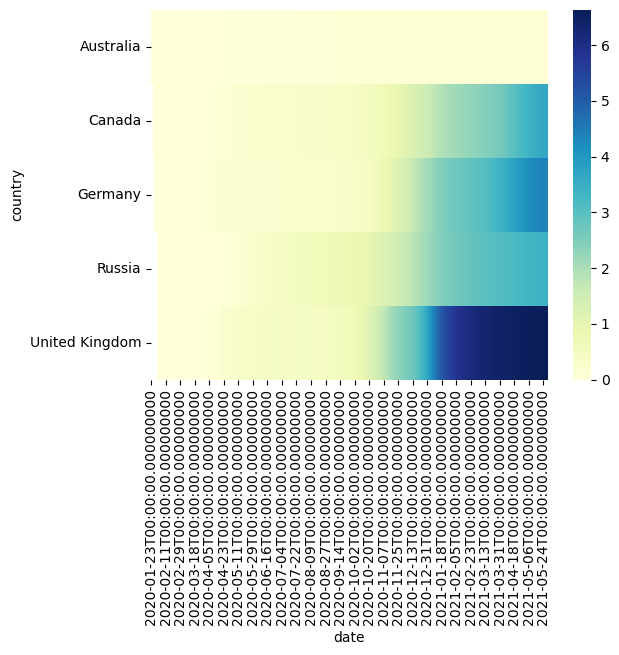

In [14]:
croped_covid_df['confirmed_per_hundred']=(croped_covid_df['confirmed']/croped_covid_df['population'])*100
cr_pivot=croped_covid_df.pivot_table(values='confirmed_per_hundred', index='country', columns='date')

heatmap=sns.heatmap(
    data=cr_pivot,
    cmap='YlGnBu'
)

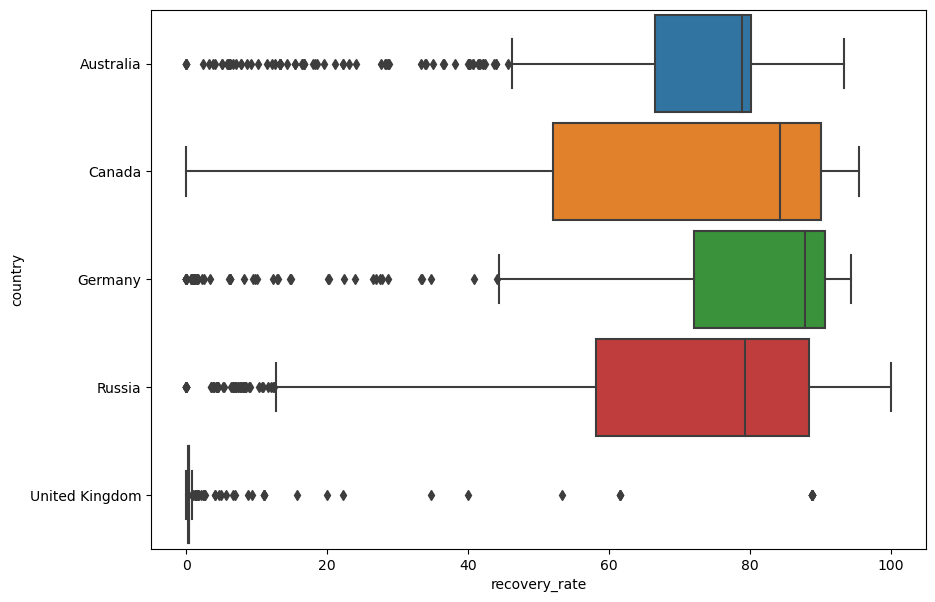

In [15]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recovery_rate',
    orient='h',
    width=0.9
)

In [16]:
import plotly
import plotly.express as px

line_data = covid_df.groupby('date', as_index=False).sum()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y=['confirmed', 'recovered', 'deaths', 'active'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

C:\Users\user\AppData\Local\Temp\ipykernel_19084\1390546553.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  line_data = covid_df.groupby('date', as_index=False).sum()


In [17]:
#считаем средний процент выздоровлений для каждой страны
bar_data = covid_df.groupby(
    by='country',
    as_index=False
)[['recovery_rate']].mean().round(2).nlargest(10, columns=['recovery_rate'])

#строим график
fig = px.bar(
    data_frame=bar_data, #датафрейм
    x="country", #ось x
    y="recovery_rate", #ось y
    color='country', #расцветка в зависимости от страны
    text = 'recovery_rate', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Top 10 Countries for Recovery Rate' #заголовок
)

#отображаем его
fig.show()

In [18]:
#считаем среднее ежедневно фиксируемое количество выздоровевших по странам
treemap_data = covid_df.groupby(
    by='country',
    as_index=False
)[['daily_recovered']].mean()

#строим график
fig = px.treemap(
    data_frame=treemap_data, #DataFrame
    path=['country'], #категориальный признак, для которого строится график
    values='daily_recovered', #параметр, который сравнивается
    height=500, #высота
    width=1000, #ширина
    title='Daily Recovered Cases by Country' #заголовок
)

#отображаем график
fig.show()

In [19]:
#преобразуем даты в строковый формат
choropleth_data = covid_df.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

#строим график
fig = px.choropleth(
    data_frame=choropleth_data, #DataFrame
    locations="country", #столбец с локациями
    locationmode = "country names", #режим сопоставления локаций с базой Plotly
    color="total_vaccinations", #от чего зависит цвет
    animation_frame="date", #анимационный бегунок
    range_color=[0, 30e6], #диапазон цвета
    title='Global Spread of COVID-19', #заголовок
    width=800, #ширина
    height=500, #высота
    color_continuous_scale='Reds' #палитра цветов
)

#отображаем график
fig.show()

In [20]:
#фильтруем таблицу по странам
countries=['United States', 'Russia', 'United Kingdom', 'Brazil', 'France']
scatter_data = covid_df[covid_df['country'].isin(countries)]

#строим график
fig = px.scatter_3d(
    data_frame=scatter_data, #DataFrame
    x = 'daily_confirmed', #ось абсцисс
    y = 'daily_deaths', #ось ординат
    z = 'daily_vaccinations', #ось аппликат
    color='country', #расцветка в зависимости от страны
    log_x=True, 
    log_y=True,
    width=1000,
    height=700
)

#отображаем график
#fig.show()

fig.write_html("data/scatter_3d.html")

In [22]:
choropleth_data = covid_df.sort_values(by='date')
choropleth_data['date'] = choropleth_data['date'].astype('string')

line= px.line(
    data_frame=choropleth_data, #DataFrame
    x='date', #ось абсцисс
    y='daily_vaccinations', #ось ординат
    height=500, #высота
    width=1000, #ширина
)

line.show()